## Calculate Membrane Test Statistics for Multiple Runs


**Protocol:**
A membrane test protocol usually consists of a small rectangular step in voltage (e.g. +/-10 mV) for a short period of time (e.g. 200 ms). This is repeated a few times (e.g. 5-10x sweeps) for more consistent data.

### Import relevant modules

In [1]:
import pyabf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import glob

ModuleNotFoundError: No module named 'pyabf'

### Set overall variables
The file_trunk is used in filenames for saving dataframes and charts. Here, the format is: "experimentDateYYYYMMDD_cellType_proteinName_"

In [2]:
file_trunk = '20220505_HEK_ChR2_'

# Set Seaborn display features
#sns.set_theme()
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.1,)

### Define modules to calculate membrane statistics
Modules for calculating: membrane resistance (Rm), access/input resistance (Ra), membrane capacitance (Cm), holding current (Ih), off-kinetics (tau). \
\
Refer to: \
https://swharden.com/pyabf/tutorial/#membrane-test \
https://swharden.com/blog/2020-10-11-model-neuron-ltspice/ 

In [3]:
def monoExpTau(data,sample_rate_hz=20000,tau=.1,step=.1):
    """Given some data which decays to zero, return its time constant (found by successive approximation)."""
    # data : input data that decays to zero
    # sample_rate_hz : the dataRate in Hz (points per sec)
    # tau : starting value for tau constant (updated by this module)
    # step : starting value for interatively adjusting tau constant
    
    if len(data)==0:
        return np.nan
    errs = [np.inf]
    normed = data/data[0]
    Xs = np.arange(len(normed))/sample_rate_hz
    while(len(errs)) < 50:
        assert len(Xs)==len(data)
        tau = np.max((0.000001,tau))
        errs.append(np.sum(np.exp(-Xs/tau)-normed))
        if np.abs(errs[-1])<0.01:
            return tau
        if (errs[-1]>0 and errs[-2]<0) or (errs[-1]<0 and errs[-2]>0):
            step/=2
        if errs[-1]<0:
            tau+=step
        elif errs[-1]>0:
            tau-=step
    return tau

def memtest(trace1, trace2, rate_hz=10000, dV=10*1e-3, avgLastFrac=.75):
    """
    Given data (pA) immediately after a voltage step, return all membrane test features.
    sig1 and sig2 are the downward/upward currents in response to the voltage step.
    """
    # trace1 : current trace between voltage change on and off (i.e. during the voltage step)
    # trace2 : current trace after voltage change off (i.e. after the voltage step)
    # rate_hz : the dataRate in Hz (points per sec)
    # dV : delta/change of the voltage (the size of the voltage step, determined by the stim protocol)
    # avgLastFrac : fraction of the traces after which to average out (in order to center traces at zero current)
    
    # This memtest dictionary is what gets returned at the end.
    mt_dict={"dV":dV*1e3}   # dV is in units Volts, "*1e3" to convert to milliVolts (mV)
    
    # subtract-out the steady state current so signals are centered at 0
    Ih1 = np.average(trace1[int(avgLastFrac*len(trace1)):])
    Ih2 = np.average(trace2[int(avgLastFrac*len(trace2)):])
    data1 = trace1-Ih1
    data2 = trace2-Ih2
    
    # Mean holding current, Ih, at baseline voltage (where baseline is 'trace2')
    mt_dict["Ih"] = Ih2     # same units as in recording, here pA
    
    # For membrane resistance, Rm, compare the steady-state currents to calculate membrane resistance
    dI = (np.abs(Ih2-Ih1)*1e-12)  # difference in current for two steady-states, dI is in Amps ("*1e-12" converts pA to A)
    Rm = dV/dI                    # resistance (Ohms) = voltage (Volts) / current (Amps)
    mt_dict["Rm"] = Rm*1e-6       # Rm is in units Ohms, "*1e-6" to convert to MegaOhms (MOhm)
    
    # Improve the data by averaging the two curves together
    point_count = np.min((len(trace1),len(trace2)))
    data = np.average((-data1[:point_count],data2[:point_count]),axis=0)
    
    # Find the points of the trace we intend to fit
    peakI = np.where(data==np.max(data))[0][0]
    zeroI = np.where(data[peakI:]<=0)[0]
    if len(zeroI)==0:
        zeroI = peakI
    else:
        zeroI = zeroI[0]+peakI
    
    # Fit a monoexponential curve to the data between peak and zero, and record tau
    tau = monoExpTau(data[peakI:zeroI])   # tau in seconds
    mt_dict["tau"] = tau*1e6      # tau is in units , "*1e6" to convert to microSec (us)

    # Use tau to guess what I0 probably was at the first point after the step
    I0 = np.exp((peakI/rate_hz)/tau)*data[peakI]*1e-12
    mt_dict["I0"] = I0*1e12       # I0 is in units Amps, "*1e12" to convert to picoAmps (pA)
    
    # Calculate membrane resistance, Ra = dV/I0
    Ra = dV/I0
    mt_dict["Ra"] = Ra*1e-6       # Ra is in units Ohms, "*1e-6" to convert to MegaOhms (MOhm)

    # Calculate membrane capacitance, Cm = tau/Ra
    Cm=tau/Ra
    mt_dict["Cm"] = Cm*1e12       # Cm is in units Farads, "*1e12" to convert to picoFarads (pF)
    
    return mt_dict
    
def memtest_display(mt_dict):
    """Given a memtest dictionary, show the important stuff with its units."""
    print("Rm: %.02f MOhm"%(mt_dict["Rm"]))
    print("Ra: %.02f MOhm"%(mt_dict["Ra"]))
    print("Cm: %.02f pF"%(mt_dict["Cm"]))
    print("tau: %.03f us"%(mt_dict["tau"]))
    print("Ih: %.02f pA"%(mt_dict["Ih"]))

### Create list of all abf files with "memtest" in their protocol name

In [4]:
# Generate list of all files from current directory ending in ".abf"
list_of_files = sorted(glob.glob("*.abf"))

# Create list of only those abf files that have "memtest" in their protocol name
memtestlist = []
for file in list_of_files:
    abf = pyabf.ABF(file)
    fullstring = abf.protocol
    substring = "memtest"            
    if substring in fullstring:      # Search for the substring in the fullstring
        memtestlist.append(file)     # Add the filename to the list

# Display the list
display(memtestlist)

['20220505_0000.abf',
 '20220505_0008.abf',
 '20220505_0016.abf',
 '20220505_0024.abf',
 '20220505_0032.abf']

### Remove unwanted files from list

In [5]:
memtestlist.remove('20220505_0000.abf')
display(memtestlist)

['20220505_0008.abf',
 '20220505_0016.abf',
 '20220505_0024.abf',
 '20220505_0032.abf']

### Plot example of memtest
This is to check that the voltage step epoch is found correctly for this protocol, before proceeding with the calculations.

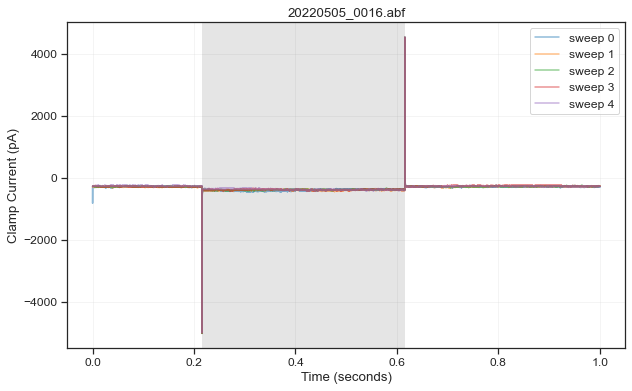

In [6]:
# Select abf file to plot and load it
file = memtestlist[1]
abf = pyabf.ABF(file)

# Extract the start and end time of the voltage-step epoch
epochNumber = 2
t1 = abf.sweepEpochs.p1s[epochNumber] * abf.dataSecPerPoint   # start of epoch, converted to time (in sec)
t2 = abf.sweepEpochs.p2s[epochNumber] * abf.dataSecPerPoint   # end of epoch, converted to time (in sec)

# Set figure parameters
plt.figure(figsize=(10, 6))
plt.ylabel(abf.sweepLabelY)
plt.xlabel(abf.sweepLabelX)
plt.title(file)
#plt.axis([0, 1, -5000, 5000])
plt.grid(alpha=.2)

# Plot each sweep in the file
for sweepN in abf.sweepList:
    abf.setSweep(sweepNumber=sweepN, channel=1)
    plt.plot(abf.sweepX, abf.sweepY, alpha=.5, label="sweep %d" % (sweepN))

# Annotate step epoch with shaded area
plt.axvspan(t1, t2, color='k', alpha=.1, lw=0)

# Compile and display plot
plt.legend()
plt.show()

### Calculate memtest statistics for all files in memtestlist
Calculate memtest statistics for all files in memtestlist and put all into a dataframe.

In [7]:
# Create database for storing statistics
dict = {'Run Count':[],
        'Memtest ID':[],
        'Date Time':[],
        'Membrane Capacitance, Cm (pF)': [],
        'Membrane Resistance, Rm (MOhm)': [],
        'Access Resistance, Ra (MOhm)': [],
        'Tau-off (us)': [],
        'Holding Current, Ih (pA)': [],
        'Voltage Step, dV (mV)': [],
        'Initial Current, I0 (pA)':[],
       }
df_memtests = pd.DataFrame(dict)

# Set a counter start-value to increment after each iteration
w = 1

# Iterate through the files in the list
for runi in memtestlist:
    
    # Load run for this iteration
    abf = pyabf.ABF(runi) 
    
    # Extract the start and end points of the voltage-step epoch (in dataPoints, not seconds)
    epochNumber = 2
    step_start = abf.sweepEpochs.p1s[epochNumber]+1 #4313   # The sweepEpochs calls need to be right up front
    step_end = abf.sweepEpochs.p2s[epochNumber]+1 #12313
    dataRate = abf.dataRate
    step_size = abs(abf.sweepEpochs.levels[2])*1e-3    # The change in voltage for the voltage-step epoch
    
    # Calculate the mean current values across all sweeps in the memtest protocol
    df_fulltraces = pd.DataFrame({})        # Create an empty dataframe
    df_fulltraces['time (s)'] = abf.sweepX  # Put the X-values into the dataframe
    totalsweeps = abf.sweepCount
    for sweep in range(totalsweeps):        # Iterate through all sweeps and add their Y-values to new columns in the dataframe
        abf.setSweep(sweepNumber=sweep, channel=1)
        df_fulltraces[sweep] = abf.sweepY
    df_fulltraces['Mean trace'] = df_fulltraces.iloc[:, 1:totalsweeps].mean(axis=1)  # Calculate the mean of all the Y-value columns and add to dataframe

    # Split the full trace up into sections for calcs
    s2 = df_fulltraces['Mean trace'].iloc[step_start:step_end]    # Y-values (current) for voltage-step epoch
    s2x = df_fulltraces['time (s)'].iloc[step_start:step_end]     # X-values (time) for voltage-step epoch
    s3 = df_fulltraces['Mean trace'].iloc[step_end:]              # Y-values (current) for after voltage-step epoch
    s3x = df_fulltraces['time (s)'].iloc[step_end:]               # X-values (time) for after voltage-step epoch
    
    # Call memtest module to perform calculations
    mt_dict = memtest(s2, s3, rate_hz=dataRate, dV=step_size, avgLastFrac=.75)
    
    # Add values from the output dictionary into the dataframe
    df_memtests.loc[len(df_memtests.index)] = [
        w, 
        abf.abfID, 
        abf.abfDateTime, 
        mt_dict['Cm'], 
        mt_dict['Rm'], 
        mt_dict['Ra'],
        mt_dict['tau'],
        mt_dict['Ih'],
        mt_dict['dV'],
        mt_dict['I0'],
    ]

    w += 1    # Increment the counter

display(df_memtests)

,Run Count,Memtest ID,Date Time,"Membrane Capacitance, Cm (pF)","Membrane Resistance, Rm (MOhm)","Access Resistance, Ra (MOhm)",Tau-off (us),"Holding Current, Ih (pA)","Voltage Step, dV (mV)","Initial Current, I0 (pA)"
0,1.0,20220505_0008,2022-05-05 10:10:20.381,13.929787,246.941678,4.124795,57.457520,-149.394180,20.0,4848.725586
1,2.0,20220505_0016,2022-05-05 10:28:55.361,19.361392,191.932936,4.228600,81.871582,-266.282776,20.0,4729.697754
2,3.0,20220505_0024,2022-05-05 10:49:45.165,21.005489,765.339921,3.643381,76.531006,-103.928474,20.0,5489.406250
3,4.0,20220505_0032,2022-05-05 11:10:06.750,21.361050,264.462863,3.904184,83.397461,-231.233841,20.0,5122.709961


### Add columns for cell labels (manual annotation)


In [8]:
# Write the lists
cellpatchID = []   # For a particular date, what number cell does each memtest correspond to?
cellpatchID += 1* ['02']
cellpatchID += 1* ['03']
cellpatchID += 2* ['04']

construct = []  # What is the protein variant's name?
construct += 1* ['wildtype']
construct += 1* ['mutantX']
construct += 2* ['mutantY']

initialTest = []  # Was this the first memtest for this cell? (There may be repeated membrane tests for the same cell.)
initialTest += 3 * [True]
initialTest += 1 * [False]

# Add the lists to the dataframe as new columns
df_memtests["Cell patch ID"] = cellpatchID
df_memtests["Construct"] = construct
df_memtests["Initial Memtest"] = initialTest

# Change the datatype of a column
df_memtests = df_memtests.astype({'Run Count': int}) # Run Count column to integer

# Make a unique cell ID by combining the date with the cellpatchID => into new column "Date_Cell"
df_memtests['Date'] = df_memtests['Memtest ID'].str.replace(r'\_.*', '', regex=True)   # pull out date from "Run ID"
df_memtests['Date_Cell'] = df_memtests['Date'] + "_" + df_memtests['Cell patch ID'].astype(str)   # combine "Date" and "Cell patch ID"

# Display the dataframe
display(df_memtests)

,Run Count,Memtest ID,Date Time,"Membrane Capacitance, Cm (pF)","Membrane Resistance, Rm (MOhm)","Access Resistance, Ra (MOhm)",Tau-off (us),"Holding Current, Ih (pA)","Voltage Step, dV (mV)","Initial Current, I0 (pA)",Cell patch ID,Construct,Initial Memtest,Date,Date_Cell
0,1,20220505_0008,2022-05-05 10:10:20.381,13.929787,246.941678,4.124795,57.457520,-149.394180,20.0,4848.725586,02,wildtype,True,20220505,20220505_02
1,2,20220505_0016,2022-05-05 10:28:55.361,19.361392,191.932936,4.228600,81.871582,-266.282776,20.0,4729.697754,03,mutantX,True,20220505,20220505_03
2,3,20220505_0024,2022-05-05 10:49:45.165,21.005489,765.339921,3.643381,76.531006,-103.928474,20.0,5489.406250,04,mutantY,True,20220505,20220505_04
3,4,20220505_0032,2022-05-05 11:10:06.750,21.361050,264.462863,3.904184,83.397461,-231.233841,20.0,5122.709961,04,mutantY,False,20220505,20220505_04


### Plot all membrane statistics to compare within and between categories
The categories here are the Construct names.

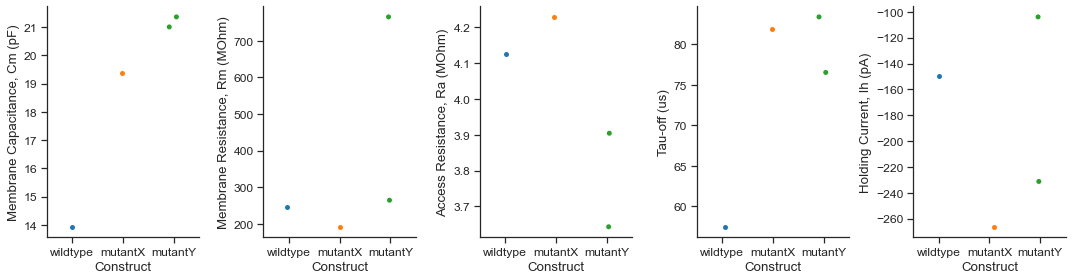

In [26]:
# Set category column for X-axis
xcol = "Construct"

# List of statistics (column names) to plot
ycol = ['Membrane Capacitance, Cm (pF)', 
        'Membrane Resistance, Rm (MOhm)', 
        'Access Resistance, Ra (MOhm)', 
        'Tau-off (us)', 
        'Holding Current, Ih (pA)',
        # add more statistics' names here for more plots
       ]
nSubplots = len(ycol)
nSubplots_list = np.arange(0,len(ycol))

# Plot the data from each column in the dataframe
f, axs = plt.subplots(1, nSubplots, figsize=((nSubplots*3), 4), sharey=False)
for i,j in zip(ycol, nSubplots_list):
    sns.stripplot(x=xcol, y=i, data=df_memtests, ax=axs[j])
    #plt.xticks(rotation=45)

# Seaborn formatting
f.tight_layout()
sns.despine(fig=f)

### Save figure as a png file

In [10]:
f.figure.savefig(file_trunk + "memtests_stats.png")

### Calculate the mean and standard deviation for each statistic within each category

In [18]:
df_memtest_mean = df_memtests.groupby(["Construct"]).mean()
df_memtest_mean

,Run Count,"Membrane Capacitance, Cm (pF)","Membrane Resistance, Rm (MOhm)","Access Resistance, Ra (MOhm)",Tau-off (us),"Holding Current, Ih (pA)","Voltage Step, dV (mV)","Initial Current, I0 (pA)",Initial Memtest
Construct,,,,,,,,,
mutantX,2.0,19.361392,191.932936,4.228600,81.871582,-266.282776,20.0,4729.697754,1.0
mutantY,3.5,21.183270,514.901392,3.773782,79.964233,-167.581161,20.0,5306.058105,0.5
wildtype,1.0,13.929787,246.941678,4.124795,57.457520,-149.394180,20.0,4848.725586,1.0


In [19]:
df_memtest_sdev = df_memtests.groupby(["Construct"]).std()
df_memtest_sdev

,Run Count,"Membrane Capacitance, Cm (pF)","Membrane Resistance, Rm (MOhm)","Access Resistance, Ra (MOhm)",Tau-off (us),"Holding Current, Ih (pA)","Voltage Step, dV (mV)","Initial Current, I0 (pA)",Initial Memtest
Construct,,,,,,,,,
mutantX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mutantY,0.707107,0.25142,354.173564,0.184415,4.855317,90.018488,0.0,259.293433,0.707107
wildtype,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Export dataframe to csv file

In [20]:
df_memtests.to_csv(file_trunk + 'memtests_stats.csv', index=False)
df_memtest_mean.to_csv(file_trunk + 'memtests_stats_byConstruct_mean.csv', index=False)
df_memtest_sdev.to_csv(file_trunk + 'memtests_stats_byConstruct_stdev.csv', index=False)